# Some experiments on a 5 substations test case

To demonstrate the use of the grid2op framework, we propose here to show how to make some quick studies on a purely fictious test case, a 5 bus system.

This system should not be used for deep research purpose. It is provided here as an example and a tool to get used to how some analyses can be performed using grid2op.

First, we can create a environment:

In [1]:
import grid2op
from tqdm.notebook import tqdm  # for easy progress bar
from grid2op.PlotGrid import PlotMatplot
env = grid2op.make("rte_case5_example", test=True)

/home/benjamin/Documents/grid2op_dev/getting_started/grid2op/MakeEnv/Make.py:240: UserWarning:

You are using a development environment. This environment is not intended for training agents.



## Inspect the powergrid

In grid2op, to make more concrete the powergrid, we also added some visual capabilities to represent, for example, the names of the objects on the grid, or the thermal limit, or any other data you want. All of that is for now only available in the matplotlib "plot helper" and can be accessed as followed.

### Plotting the layout of the graph
This utility function allows you to visualize where are the object located on the map. Each object has its own color, and is represented with its name and its id (id starts at 0, following python convention).

In [2]:
plot_helper = PlotMatplot(env.observation_space)

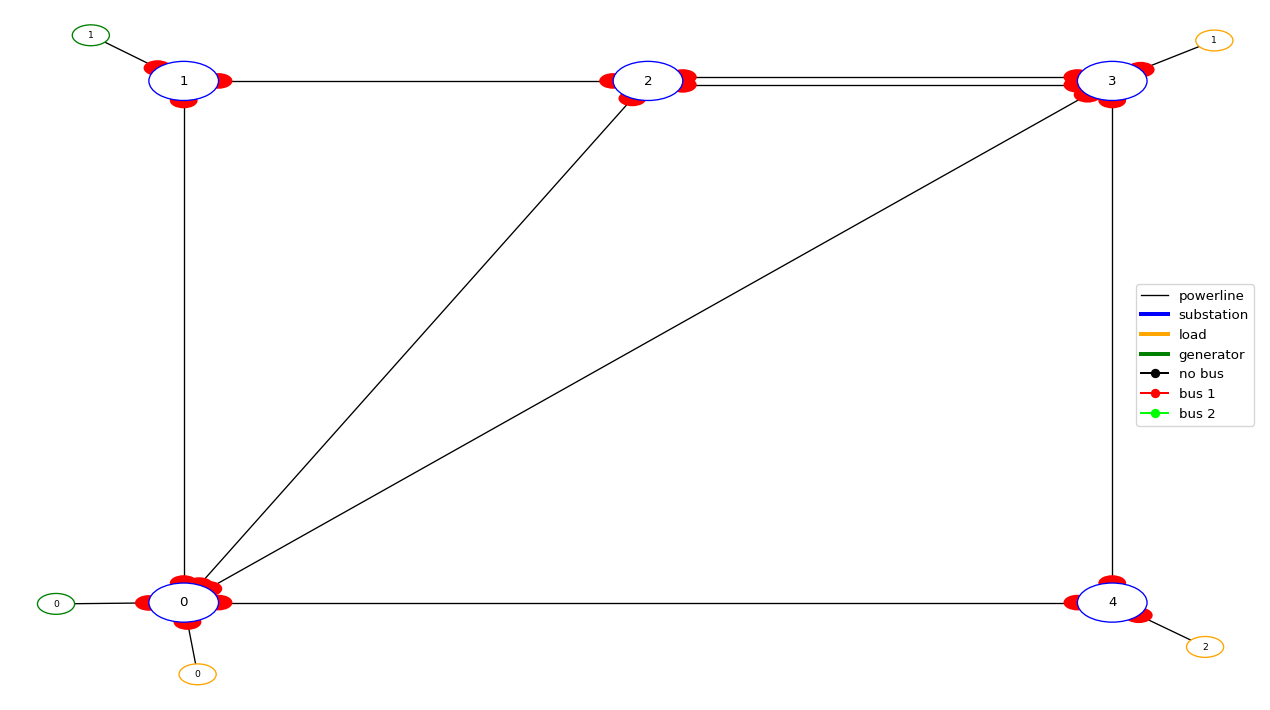

In [3]:
_ = plot_helper.plot_layout()

### Visualizing data on the grid

It is, with the same method, also possible to visualize any data on the powergrid, for example, we can inspect the thermal limit (line property) as follow:

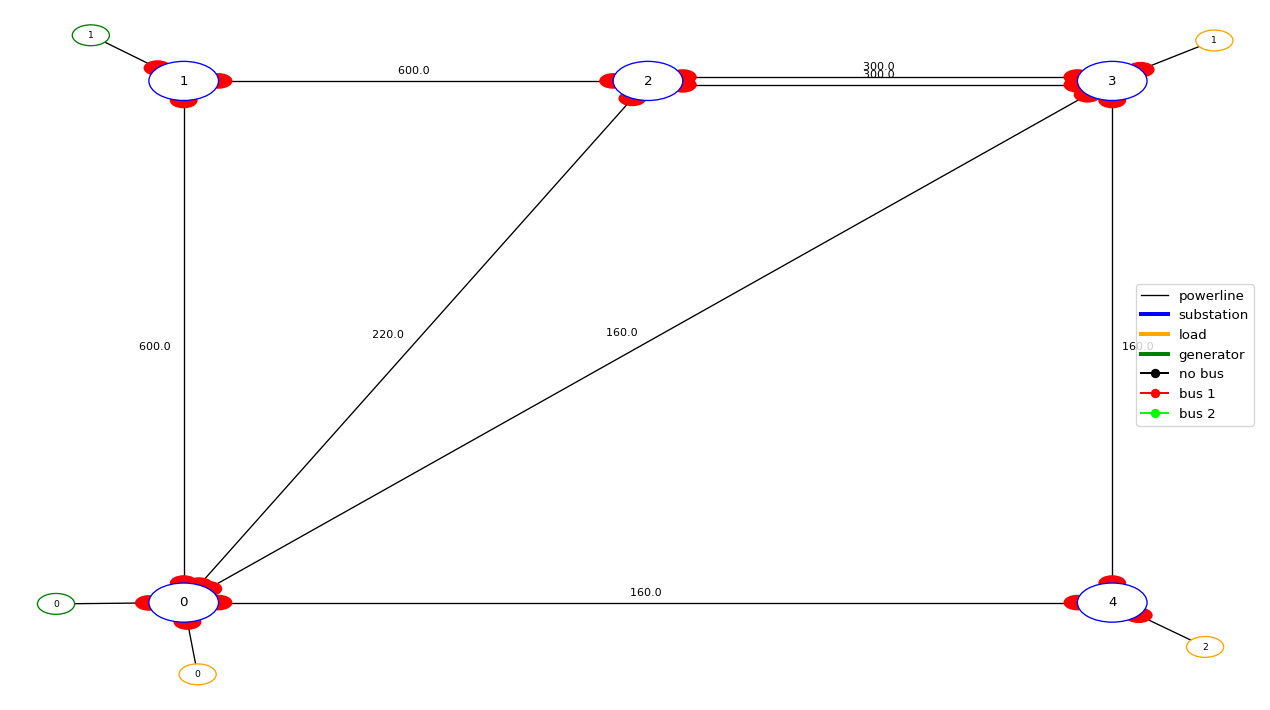

In [4]:
_ = plot_helper.plot_info(line_values=env._thermal_limit_a)

Similarly, it is possible to display some data about the generators, for example the maximum value of power they can produce.

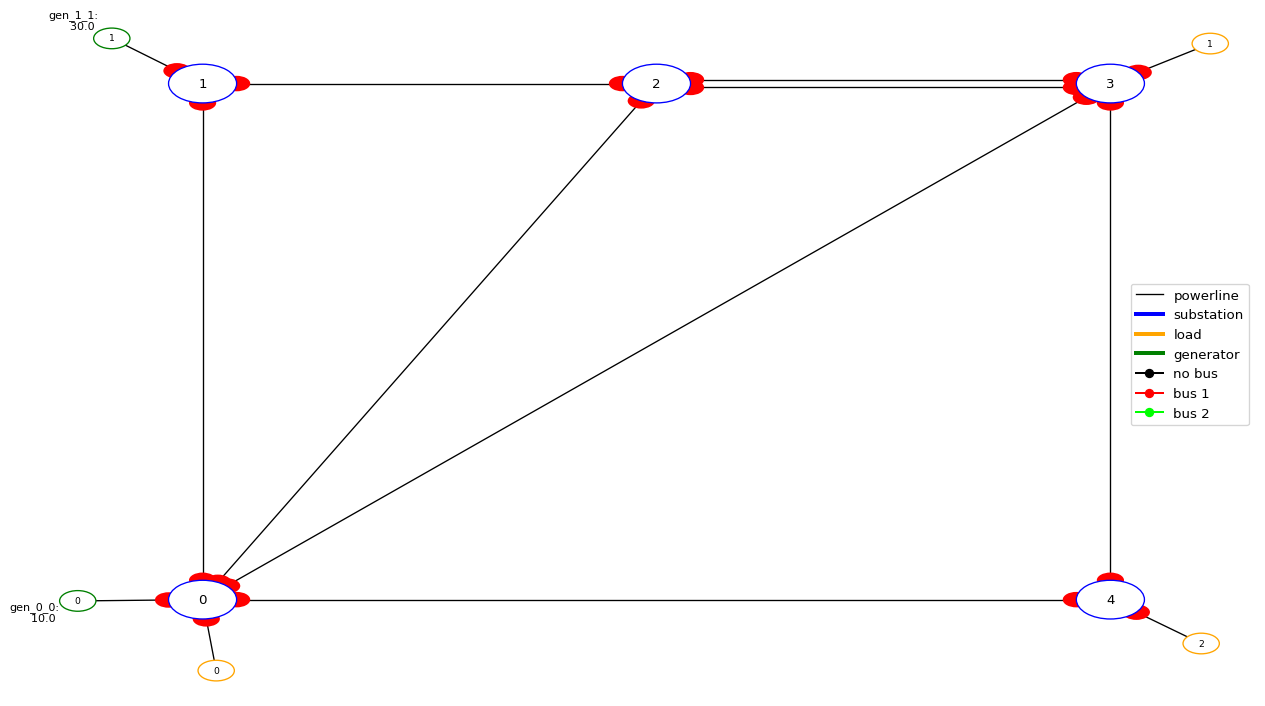

In [5]:
_ = plot_helper.plot_info(gen_values=env.gen_pmax)

Of course we can also project on the powergrid some information about the loads, for example their ID

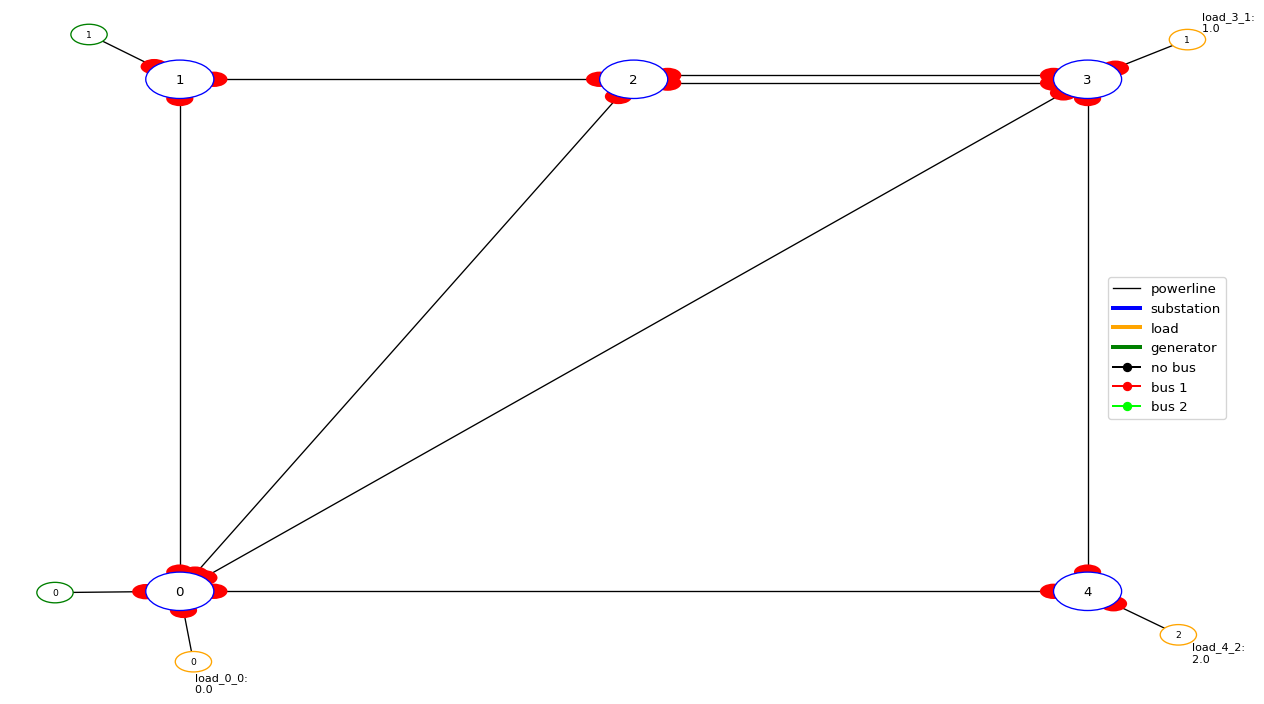

In [6]:
_ = plot_helper.plot_info(load_values=[el for el in range(env.n_load)])

## Create an agent

Now we can see how well the "do nothing" agent (the most basic imaginable) can performe, using some "gym like" methods

In [7]:
from grid2op.Agent import DoNothingAgent
my_agent = DoNothingAgent(env.action_space)

Now do the standard gym loop, and we save all the observations:

In [8]:
all_obs = []
obs = env.reset()
all_obs.append(obs)
reward = env.reward_range[0]
done = False
nb_step = 0
with tqdm(total=env.chronics_handler.max_timestep()) as pbar:
    while True:
        action = my_agent.act(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        pbar.update(1)
        if done:
            break
        all_obs.append(obs)
        nb_step += 1

We can check if the episode has been completed, or if there has been a game over:

In [9]:
print("Number of timesteps computed: {}".format(nb_step))
print("Total maximum number of timesteps possible: {}".format(env.chronics_handler.max_timestep()))

Number of timesteps computed: 94
Total maximum number of timesteps possible: 2016


As we see here, there is a game over: the agent successfully managed 94 timesteps, while the episode could have lasted 2016.

Let's try to investigate this, for example by plotting the last observation. First we need to create a utilities that will make the plot:

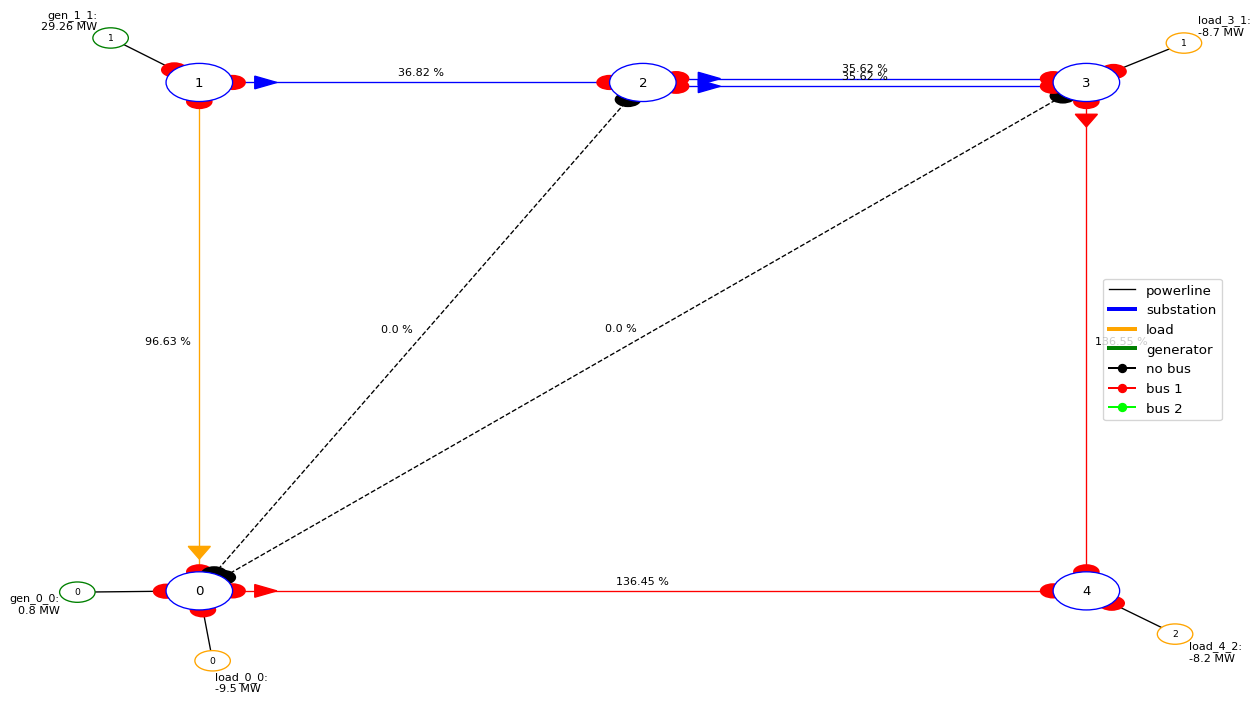

In [10]:
last_obs = all_obs[-1]
_ = plot_helper.plot_obs(last_obs)

As we can see, the last obsevation is pretty clear: 4 powerlines have been disconnected, thus isolating the load on the bottom right. This lead to a game over. 

It's also possible, of course, to inspect the previous state, just before this one:

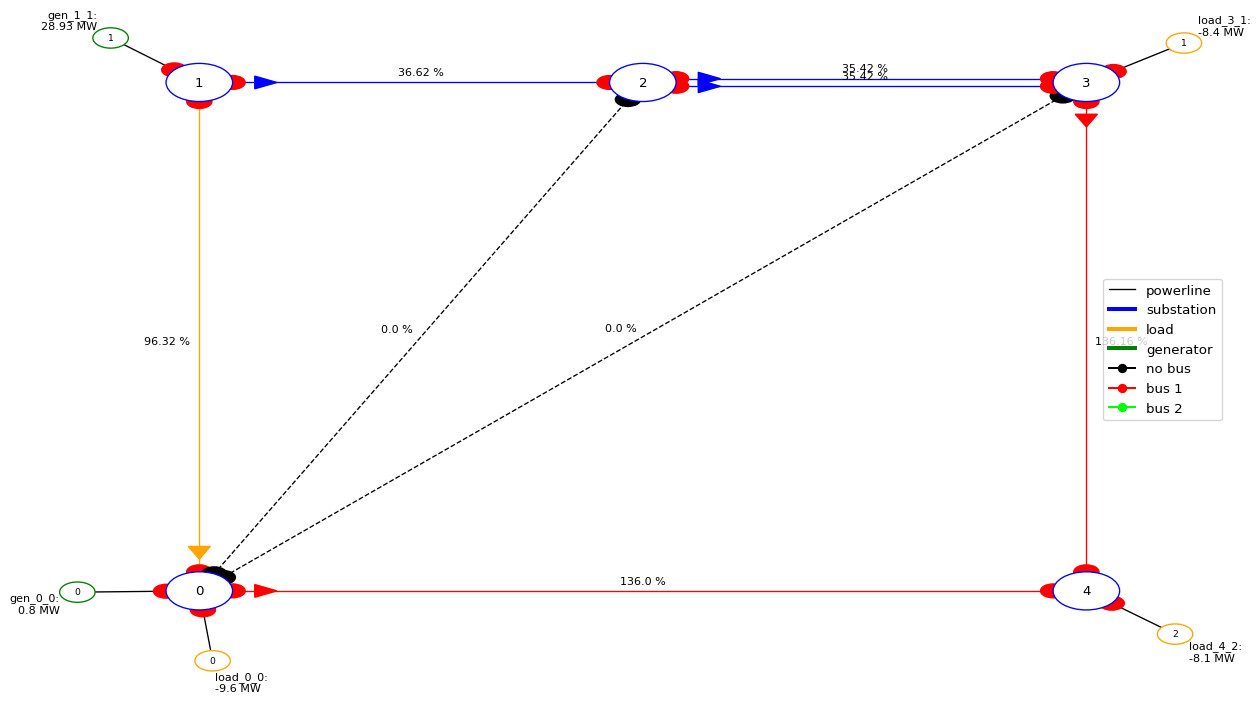

In [11]:
previous_obs = all_obs[-2]
_ = plot_helper.plot_obs(previous_obs)

And now we can know the cause for this problem: all the powerlines that could provide power on the bottom right load are overloaded in this situation, so the protection worked and disconnect them to prevent hurting the surroundings.